## Milestone 3
### Author: Emily McAfee
#### Faulty product identification

In [1]:
# Import packages
# Data cleaning/exploration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Smote
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


# RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Forward feature selection
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# LASSO & ridge regression
from sklearn import linear_model

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Read and merge data

In [2]:
# Load in data
filename = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secomdf = pd.read_csv(filename, sep = " ", header = None)

In [3]:
# Load in labels
filename2 = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secomlabels = pd.read_csv(filename2, sep = " ", header = None)

In [4]:
# Check data
secomdf.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [5]:
# Check labels
secomlabels.head()

,0,1
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [6]:
# Work with labels data
# Rename label columns
secomlabels.columns = ['class', 'datetime']

# Check data
secomlabels.head()

,class,datetime
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [7]:
# Bring together both original dataframe and labels dataframe
newdf = pd.concat([secomdf, secomlabels], axis = 1)

#Check new df
print(newdf.dtypes)
print(newdf.head())

0           float64
1           float64
2           float64
3           float64
4           float64
             ...   
587         float64
588         float64
589         float64
class         int64
datetime     object
Length: 592, dtype: object
         0        1          2          3       4      5         6       7  \
0  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   97.6133  0.1242   
1  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0  102.3433  0.1247   
2  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   95.4878  0.1241   
3  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0  104.2367  0.1217   
4  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0  100.3967  0.1235   

        8       9  ...     582     583     584      585     586     587  \
0  1.5005  0.0162  ...  0.5005  0.0118  0.0035   2.3630     NaN     NaN   
1  1.4966 -0.0005  ...  0.5019  0.0223  0.0055   4.4447  0.0096  0.0201   
2  1.4436  0.0041  ...  0.4958  0.0157  0.0039   3.1745  0.

Clean and prepare data

In [8]:
# Make datetime object
newdf.datetime = pd.to_datetime(newdf.datetime, format = '%d/%m/%Y %H:%M:%S')

# Check dtypes
newdf.dtypes


0                  float64
1                  float64
2                  float64
3                  float64
4                  float64
                 ...      
587                float64
588                float64
589                float64
class                int64
datetime    datetime64[ns]
Length: 592, dtype: object

In [9]:
newdf2 = newdf.copy()
# Make datetime the index so that it is not treated as a feature
newdf2.set_index('datetime', inplace = True)

# Check data
newdf2.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,class
datetime,,,,,,,,,,,,,,,,,,,,,
2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [10]:
# See how many NaNs are in the dataframe
sum(len(newdf2) - newdf2.count())

# See how many non-non values there are 
sum(newdf2.count())

# See how many datapoints in all
(sum(len(newdf2) - newdf2.count())) + (sum(newdf2.count()))

926097

In [11]:
# Seems like there's not too many NaNs - we'll impute the mean for them
newdf3 = newdf2.fillna(newdf2.mean())
newdf3.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,class
datetime,,,,,,,,,,,,,,,,,,,,,
2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,97.934373,0.5005,0.0118,0.0035,2.3630,0.021458,0.016475,0.005283,99.670066,-1
2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.204500,0.5019,0.0223,0.0055,4.4447,0.009600,0.020100,0.006000,208.204500,-1
2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.860200,0.4958,0.0157,0.0039,3.1745,0.058400,0.048400,0.014800,82.860200,1
2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.843200,0.4990,0.0103,0.0025,2.0544,0.020200,0.014900,0.004400,73.843200,-1
2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,97.934373,0.4800,0.4766,0.1045,99.3032,0.020200,0.014900,0.004400,73.843200,-1


In [12]:
# Change class to 0 and 1
newdf3['class'] = newdf3['class'].replace(-1,0)
newdf3['class'].value_counts()

0    1463
1     104
Name: class, dtype: int64

Visually explore data

In [13]:
%time newdf.mean()

CPU times: user 519 ms, sys: 37.3 ms, total: 556 ms
Wall time: 551 ms


0        3014.452896
1        2495.850231
2        2200.547318
3        1396.376627
4           4.197013
            ...     
586         0.021458
587         0.016475
588         0.005283
589        99.670066
class      -0.867262
Length: 591, dtype: float64

In [14]:
# Explore data by each day
byday = newdf3.iloc[:,:590].groupby(pd.Grouper(freq = 'D')).mean()
byday

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
datetime,,,,,,,,,,,,,,,,,,,,,
2008-07-19,3001.863333,2515.117500,2219.899067,1272.050808,1.133158,100.0,101.899450,0.122492,1.509575,0.002892,...,0.006657,94.412627,0.496558,0.055950,0.012800,11.536283,0.026955,0.020356,0.006549,88.055781
2008-07-20,2920.070000,2507.400000,2195.122200,1046.146800,1.320400,100.0,103.340000,0.122300,1.531000,-0.025900,...,0.003400,52.203900,0.495000,0.015300,0.004100,3.092600,0.018800,0.009800,0.003400,52.203900
2008-07-21,3007.705000,2579.375000,2204.527750,912.700250,1.379600,100.0,106.360000,0.121850,1.485500,-0.003250,...,0.006898,120.421186,0.505550,0.012250,0.003200,2.427300,0.019500,0.019350,0.005900,97.555950
2008-07-22,3010.836667,2528.990000,2230.320870,1163.552705,1.839102,100.0,104.568451,0.120817,1.542600,-0.004483,...,0.004681,87.222520,0.501217,0.011567,0.003133,2.307733,0.019733,0.014050,0.003917,73.481400
2008-07-23,3008.361448,2489.650000,2207.388900,962.531700,1.204300,100.0,104.031100,0.121000,1.551200,0.009850,...,0.004900,74.506600,0.496200,0.012550,0.003900,2.528900,0.021250,0.017300,0.004900,74.506600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-10-13,3031.895000,2494.392727,2193.725759,1680.836595,1.343614,100.0,100.282014,0.122995,1.377550,0.013550,...,0.005671,154.162496,0.500364,0.015855,0.003945,3.171818,0.013218,0.019782,0.006459,236.893368
2008-10-14,2975.995000,2494.285000,2193.480556,1803.461906,1.428419,100.0,97.645219,0.123462,1.379981,-0.000238,...,0.006730,96.332920,0.501119,0.017344,0.004181,3.452631,0.022219,0.021419,0.006975,99.062931
2008-10-15,3032.822353,2489.346471,2198.327441,1788.045859,1.458500,100.0,99.164753,0.123735,1.374421,0.001065,...,0.005040,95.097128,0.499485,0.016097,0.003876,3.220874,0.019032,0.015521,0.005132,97.868512


(array([733238., 733255., 733269., 733286., 733300., 733316., 733330.]),
 <a list of 7 Text xticklabel objects>)

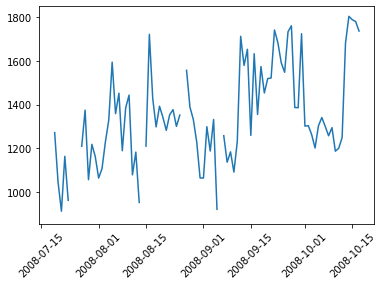

In [15]:
# Plot column 3 by day
plt.plot(byday.index, byday.iloc[:,3])
plt.xticks(rotation=45)

In [16]:
# Plot 3 random days and count how many 0s, 1s
# Pick 3 random days
byday.sample(3)

# Pull all these days from full df (based off of original iteration of 'sample')
begoct = newdf3.loc['2008-10-04']
endaug = newdf3.loc['2008-08-22']
endjul = newdf3.loc['2008-07-20']

Text(0.5, 1.0, 'Counts of satisfactory (0) and faulty (1) diapers on October 4th, 2008')

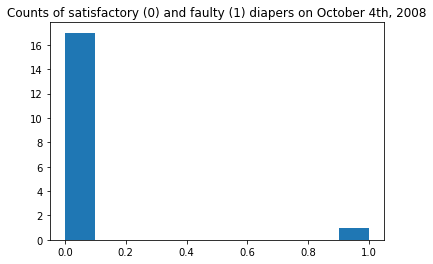

In [17]:
# begoct
plt.hist(begoct['class'])
plt.title('Counts of satisfactory (0) and faulty (1) diapers on October 4th, 2008')

Text(0.5, 1.0, 'Counts of satisfactory (0) and faulty (1) diapers on August 22nd, 2008')

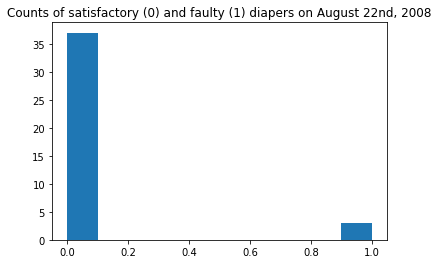

In [18]:
# endaug
plt.hist(endaug['class'])
plt.title('Counts of satisfactory (0) and faulty (1) diapers on August 22nd, 2008')

Text(0.5, 1.0, 'Counts of satisfactory (0) and faulty (1) diapers on July 20th, 2008')

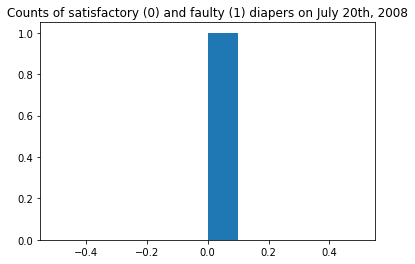

In [19]:
# endjul
plt.hist(endjul['class'])
plt.title('Counts of satisfactory (0) and faulty (1) diapers on July 20th, 2008')

### 1. Build a simple neural networks model

In [20]:
# Establish features
x = newdf3.loc[:, newdf3.columns != 'class']

# Establish target label (variable we are trying to predict)
y = newdf3['class']

Handle class imbalance problem

In [21]:
# Apply SMOTE for class imbalance
# What did the imbalance look like before SMOTE
print('Original dataset shape {}'.format(Counter(y)))

# Apply SMOTE
sm = SMOTE(random_state = 42)
x_res, y_res = sm.fit_sample(x,y)

# What does the imbalance look like after SMOTE
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 1463, 1: 104})
Resampled dataset shape Counter({0: 1463, 1: 1463})


In [22]:
# Make into arrays
x_res = x_res.values.reshape(2926, 590)
y_res = y_res.values.reshape(2926,1)

In [23]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size = 0.2)

In [24]:
# Train a simple NN
from sklearn.neural_network import MLPClassifier

# Create 3 layers with 10 nodes each
mlp = MLPClassifier(hidden_layer_sizes = (30, 30, 30), max_iter = 200)

# Fit model
mlp.fit(x_train, y_train.ravel())

# Make predictions
pred = mlp.predict(x_test)

In [25]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[236  40]
 [ 10 300]]
              precision    recall  f1-score   support

           0       0.96      0.86      0.90       276
           1       0.88      0.97      0.92       310

    accuracy                           0.91       586
   macro avg       0.92      0.91      0.91       586
weighted avg       0.92      0.91      0.91       586



#### Let's see what the best parameters are

In [26]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [27]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(x_train, y_train)

/Users/e.kubicek/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08,
                                     hidden_layer_sizes=(30, 30, 30),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_s...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
    

In [28]:
# Look at results
y_true, y_pred = y_test, clf.predict(x_test)
print(classification_report(y_true, y_pred))
print('Best performing kernel/settings:')
print(clf.best_params_)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       276
           1       0.93      0.87      0.90       310

    accuracy                           0.90       586
   macro avg       0.90      0.90      0.90       586
weighted avg       0.90      0.90      0.90       586

Best performing kernel/settings:
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


### 2. Build a DNN model

In [29]:
# Define the model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(12, input_dim = 590, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [30]:
# Compile model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [31]:
# Fit the model
model.fit(x_res,y_res, epochs = 10, batch_size = 50)

Epoch 1/10
2926/2926 [==============================] - 0s 82us/step - loss: 30.8866 - accuracy: 0.5116
Epoch 2/10
2926/2926 [==============================] - 0s 39us/step - loss: 8.1802 - accuracy: 0.5748
Epoch 3/10
2926/2926 [==============================] - 0s 38us/step - loss: 4.9914 - accuracy: 0.6032
Epoch 4/10
2926/2926 [==============================] - 0s 38us/step - loss: 4.1792 - accuracy: 0.6258
Epoch 5/10
2926/2926 [==============================] - 0s 38us/step - loss: 3.2793 - accuracy: 0.6476
Epoch 6/10
2926/2926 [==============================] - 0s 40us/step - loss: 2.8543 - accuracy: 0.6524
Epoch 7/10
2926/2926 [==============================] - 0s 40us/step - loss: 2.4272 - accuracy: 0.6582
Epoch 8/10
2926/2926 [==============================] - 0s 44us/step - loss: 2.1114 - accuracy: 0.6722
Epoch 9/10
2926/2926 [==============================] - 0s 46us/step - loss: 2.1125 - accuracy: 0.6640
Epoch 10/10
2926/2926 [==============================] - 0s 47us/step - 

In [32]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_res, y_res)
print('Test accuracy: %.2f' % (test_acc*100))

2926/2926 [==============================] - 0s 33us/step
Test accuracy: 56.22


### 4. Build a RNN model

In [33]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [34]:
# create and fit the LSTM network
from keras.layers import LSTM

timesteps = 1
model = Sequential()
model.add(LSTM(4, input_shape=(timesteps, 590)))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [35]:
# Fit nework
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=64)

Train on 2340 samples, validate on 586 samples
Epoch 1/3
2340/2340 [==============================] - 1s 256us/step - loss: 1.4615 - val_loss: 2.1128
Epoch 2/3
2340/2340 [==============================] - 0s 45us/step - loss: 1.0439 - val_loss: 1.0521
Epoch 3/3
2340/2340 [==============================] - 0s 55us/step - loss: 0.9804 - val_loss: 1.0516


In [36]:
# Evaluate the model
print('Test accuracy: %.2f' % (model.evaluate(x_test, y_test, verbose=0)*100))

Test accuracy: 105.16


### 4. Summarize your findings with examples. Explain what the manufacturer should focus on to optimize the diaper manufacturinng process.

In [37]:
print('\n# Show accuracies for all neural network models:')
print('88% = Simple neural network')
print('55% = DNN accuracy')
print('70% = RNN accuracy')


# Show accuracies for all neural network models:
88% = Simple neural network
55% = DNN accuracy
70% = RNN accuracy


In [38]:
# Test the simple NN model against a data point
np.random.seed(42)
weights = np.random.rand(590,1)
bias = np.random.rand(1)
lr = 0.05

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x)*(1-sigmoid(x))

for epoch in range(2000):
    inputs = x_res

    # feedforward step1
    XW = np.dot(x_res, weights) + bias

    #feedforward step2
    z = sigmoid(XW)

    # backpropagation step 1
    error = z - y_res

    print(error.sum())

    # backpropagation step 2
    dcost_dpred = error
    dpred_dz = sigmoid_der(z)

    z_delta = dcost_dpred * dpred_dz

    inputs = x_res.T
    weights -= lr * np.dot(inputs, z_delta)

    for num in z_delta:
        bias -= lr * num

        

1463.0
-1463.0
1463.0
-1463.0
1463.0
-1463.0
1463.0
-1463.0
1463.0
-1309.0
1463.0
376.0
-860.0
1463.0


/Users/e.kubicek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


-1463.0
1463.0
-1172.0
1463.0
-421.0
1463.0
-1463.0
1463.0
-1463.0
1463.0
-1256.0
1463.0
190.0
1337.0
-1463.0
1463.0
-1463.0
1463.0
-1463.0
1463.0
-1331.0
1463.0
38.0
1452.0
-1463.0
1463.0
-1463.0
1463.0
-1463.0
1463.0
-1324.0
1463.0
89.0
1382.0
-1463.0
1463.0
-1463.0
1463.0
-1462.0
1463.0
-1285.0
1463.0
-74.0
1452.0
-1463.0
1463.0
-1463.0
1463.0
-1337.0
1463.0
-1307.0
1463.0
-197.0
1452.0
-1463.0
1463.0
-1463.0
1463.0
-1331.0
1463.0
-845.0
1463.0
-1337.0
1463.0
-1243.0
1463.0
-501.0
1455.0
-1463.0
1463.0
-1337.0
1463.0
-1150.0
1463.0
-1069.0
1463.0
-1271.0
1463.0
-437.0
1438.0
-1463.0
1462.0
-1425.0
1463.0
-848.0
1460.0
-1408.0
1463.0
-879.0
1460.0
-1386.0
1462.0
-836.0
1456.0
-1462.0
1462.0
-577.0
1443.0
-1463.0
1462.0
-1330.0
1462.0
-616.0
1444.0
-1463.0
1461.0
-1310.0
1462.0
-498.0
1425.0
-1463.0
1458.0
-1333.0
1462.0
-894.0
1455.0
-1341.0
1460.0
-993.0
1456.0
-1327.0
1461.0
-518.0
1413.0
-1463.0
1456.0
-1333.0
1462.0
-692.0
1440.0
-1463.0
1460.0
-1184.0
1460.0
-926.0
1454.0
-1351.

-1341.0
1447.0
-874.0
1414.0
-1336.0
1446.0
-883.0
1415.0
-1330.0
1446.0
-888.0
1415.0
-1324.0
1445.0
-891.0
1415.0
-1319.0
1444.0
-898.0
1415.0
-1307.0
1444.0
-918.0
1417.0
-1278.0
1442.0
-969.0
1425.0
-1237.0
1441.0
-990.0
1425.0
-1227.0
1440.0
-989.0
1425.0
-1227.0
1440.0
-991.0
1424.0
-1223.0
1439.0
-991.0
1422.0
-1222.0
1439.0
-988.0
1421.0
-1227.0
1439.0
-980.0
1421.0
-1241.0
1440.0
-965.0
1417.0
-1247.0
1440.0
-961.0
1417.0
-1248.0
1441.0
-969.0
1421.0
-1247.0
1441.0
-967.0
1419.0
-1245.0
1441.0
-971.0
1421.0
-1243.0
1440.0
-971.0
1421.0
-1242.0
1440.0
-974.0
1421.0
-1242.0
1440.0
-968.0
1418.0
-1242.0
1440.0
-973.0
1421.0
-1241.0
1440.0
-972.0
1420.0
-1242.0
1440.0
-969.0
1418.0
-1241.0
1441.0
-976.0
1421.0
-1239.0
1440.0
-972.0
1418.0
-1239.0
1440.0
-972.0
1418.0
-1240.0
1441.0
-973.0
1419.0
-1241.0
1441.0
-972.0
1418.0
-1239.0
1441.0
-976.0
1420.0
-1240.0
1441.0
-973.0
1418.0
-1239.0
1440.0
-970.0
1418.0
-1241.0
1440.0
-973.0
1418.0
-1239.0
1440.0
-969.0
1417.0
-1241.0
1440.0

In [39]:
single_point = np.array(x_res[0])
result = sigmoid(np.dot(single_point, weights) + bias)

# What did our model classify this as
print(result)

[0.]


/Users/e.kubicek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


In [40]:
# Check to see that the first label should be 0
y_res

array([[0],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

We were able to create a neural network with 88% accuracy when determining whether a diaper is faulty. If this tool is used, an almost 90% reduction in the amount of faulty products going out is huge for a business' bottom line. As seen in the example above, when the sensor data points are fed into the model, we are able to predict if the product is faulty or not. My recommendation would be to use the simple neural network tool to identify products that are faulty. As a next step in improving the model, data scientists could conduct some feature engineering and/or feature scaling.